# Arima Model and Exponential Smoothing

For this exercise we will be using Pandas, Numpy, Matplotlib and Statsmodels libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error
from math import sqrt

The dataset we will use is the Housing price in Dublin from January 2018 to May 2022.

In [2]:
ds_path = "./DataSets/House Sales Dublin.csv"

In the Next cell we defined a function to help Pandas parse the date into the correct format

In [3]:
def parser(x):
    return pd.datetime.strptime(x, '%d/%m/%Y')

We are only using the date and price column for this exercise,
In the next cell we will select this two columns and also rename them.

In [4]:
data_set = pd.read_csv(ds_path, dtype={'Property Size Description': 'str'}, date_parser=parser, parse_dates=['Date of Sale (dd/mm/yyyy)'])

selected_data = data_set[['Date of Sale (dd/mm/yyyy)', 'Price (€)']]
series = selected_data.copy()

series.rename(columns = {'Date of Sale (dd/mm/yyyy)':'Date', 'Price (€)':'Price'}, inplace = True)
series.head()

/tmp/ipykernel_714753/1323472867.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  return pd.datetime.strptime(x, '%d/%m/%Y')


,Date,Price
0,2017-12-31,710000.00
1,2018-01-02,627230.70
2,2018-01-02,1130000.00
3,2018-01-02,277000.00
4,2018-01-02,348017.62


As we have multiples houses sold in the same day, we will resample our data for a weekly average

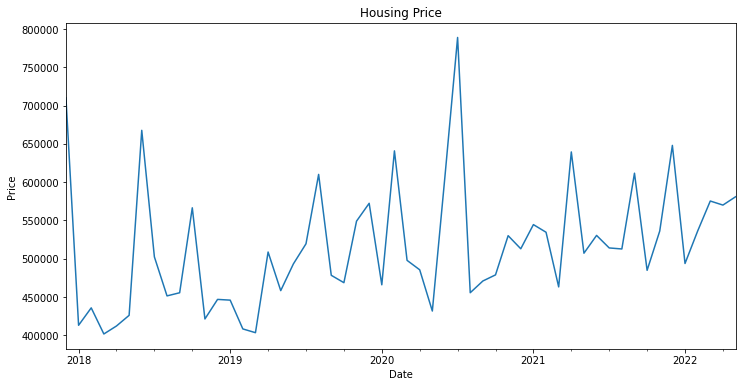

In [5]:
df = series.resample(rule='M', kind='period', origin='start_day', on='Date').mean()

fig, ax = plt.subplots(figsize=(12, 6))
df.Price.plot()
plt.title('Housing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

## Simple Exponential Smoothing

We use simple exponential smoothing for irregular data with few points, no seasonality or trend.

A simple exponential smoothing line is basically a moving average that considers all the points behind the current point but gives a rather higher weight to the more recent data. 

It requires a single parameter, alpha (a), also known as the smoothing factor, coefficient or level.

Alpha is a value between 0 and 1 that defines the weighting of the calculation.
* Recent observations greatly influence the model when alpha is closer to 1.
* Historical observations greatly influence the model when alpha is closer to 0.

/home/kelly/.local/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


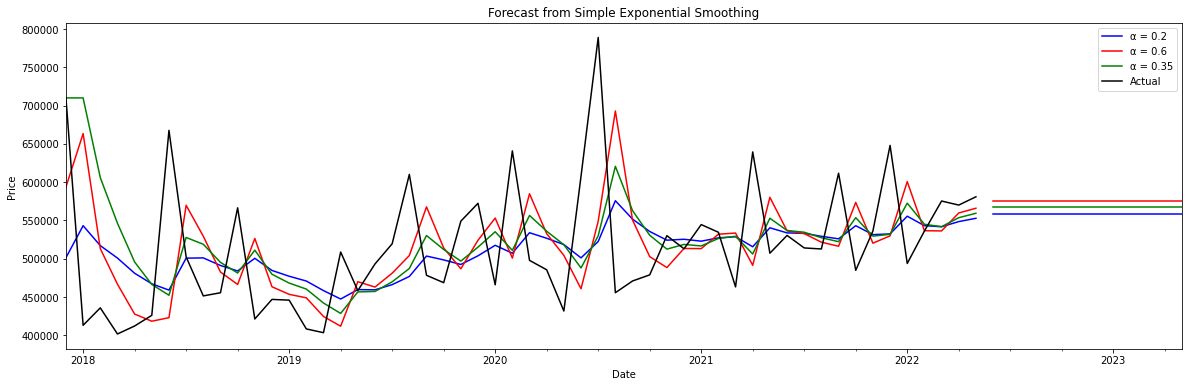

In [6]:
# Simple Exponential Smoothing

fig, ax = plt.subplots(figsize=(20, 6))

# Fit Model α = 0.2
fit1 = SimpleExpSmoothing(df).fit(smoothing_level=0.2)
# Forecast
fcast1 = fit1.forecast(12).rename('α = 0.2')

# plot α = 0.2
fcast1.plot(color='blue', legend=True)
fit1.fittedvalues.plot(color='blue')

# Fit Model α = 0.6
fit2 = SimpleExpSmoothing(df).fit(smoothing_level=0.6)
# Forecast
fcast2 = fit2.forecast(12).rename('α = 0.6')

# plot α = 0.6
fcast2.plot(color='red', legend=True)
fit2.fittedvalues.plot(color='red')

# Fit Model default α
fit3 = SimpleExpSmoothing(df).fit()
# Forecast
fcast3 = fit3.forecast(12).rename(f"α = {fit3.model.params['smoothing_level']:.2f}")

# plot default α
fcast3.plot(color='green', legend=True)
fit3.fittedvalues.plot(color='green')

# plot actual values
df.Price.plot(color='black', label="Actual", legend=True)

plt.title('Forecast from Simple Exponential Smoothing')
plt.ylabel('Price')
plt.show()

## Model Performance

In [7]:
# Total Observation
total_obs = len(df)

# Absolute Error
ae1 = [abs(forecast - df.Price.iloc[i]) for i, forecast in enumerate(fit1.fittedvalues)]
ae2 = [abs(forecast - df.Price.iloc[i]) for i, forecast in enumerate(fit2.fittedvalues)]
ae3 = [abs(forecast - df.Price.iloc[i]) for i, forecast in enumerate(fit3.fittedvalues)]

# MAE
mae1 = sum(ae1)/total_obs
mae2 = sum(ae2)/total_obs
mae3 = sum(ae3)/total_obs

#RMSE
rmse1 = sqrt(fit1.sse/total_obs)
rmse2 = sqrt(fit2.sse/total_obs)
rmse3 = sqrt(fit3.sse/total_obs)

print("α","MAE\t","RMSE", sep="\t")
print(0.2,round(mae1, 2),round(rmse1, 2), sep="\t")
print(0.6,round(mae2, 2),round(rmse2, 2), sep="\t")
print(0.35,round(mae3, 2),round(rmse3, 2), sep="\t")

α	MAE		RMSE
0.2	63705.31	83644.75
0.6	70750.85	94791.14
0.35	69754.03	93490.76


From the results above we can conclude that the model with an alpha of 0.2 had a better performance

## Double Exponential Smoothing

In addition to the alpha parameter we use a beta parameter also called smoothing trend.

The beta is a value between 0 and 1 to control the trend calculation.
* Beta closer to 1 focus on shorter-term trend.
* Beta closer to 0 focus on longer-term trend.

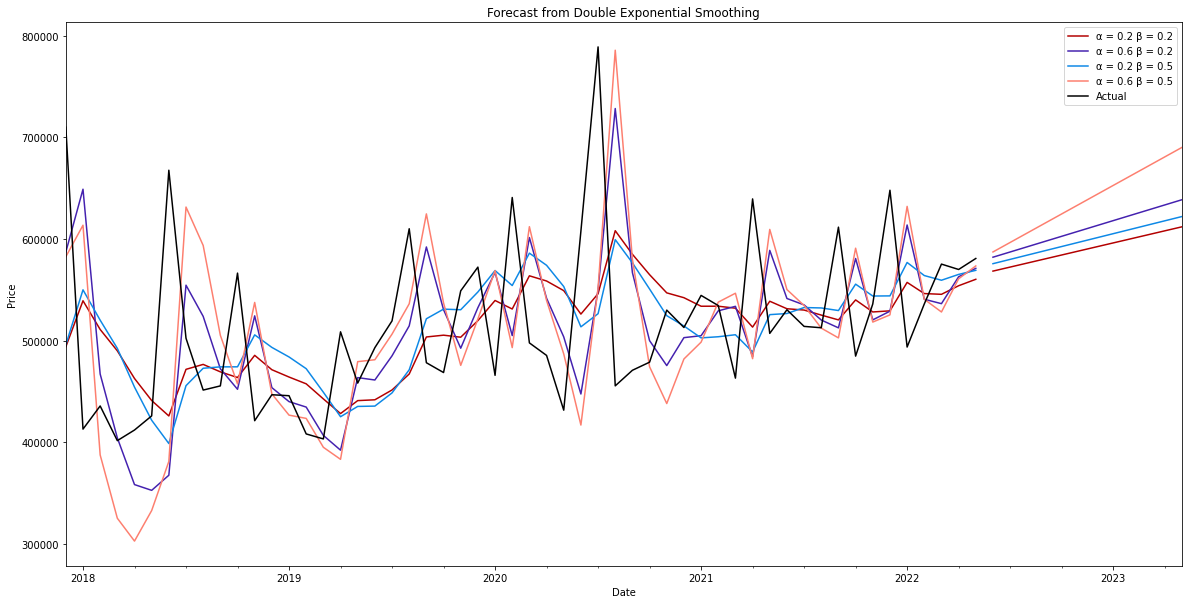

In [8]:
# Double Exponential Smoothing

fig, ax = plt.subplots(figsize=(20, 10))

# Fit Model  α = 0.2 β = 0.2
fit4 = ExponentialSmoothing(df, trend='add').fit(smoothing_level=0.2, smoothing_trend=0.2)
# Forecast
fcast4 = fit4.forecast(12).rename('α = 0.2 β = 0.2')
# plot
fcast4.plot(color='#b30000', legend=True)
fit4.fittedvalues.plot(color='#b30000')

# Fit Model  α = 0.6 β = 0.2
fit5 = ExponentialSmoothing(df, trend='add').fit(smoothing_level=0.6, smoothing_trend=0.2)
# Forecast
fcast5 = fit5.forecast(12).rename('α = 0.6 β = 0.2')
# plot
fcast5.plot(color='#4421af', legend=True)
fit5.fittedvalues.plot(color='#4421af')

# Fit Model  α = 0.2 β = 0.5
fit6 = ExponentialSmoothing(df, trend='add').fit(smoothing_level=0.2, smoothing_trend=0.5)
# Forecast
fcast6 = fit6.forecast(12).rename('α = 0.2 β = 0.5')
# plot
fcast6.plot(color='#0d88e6', legend=True)
fit6.fittedvalues.plot(color='#0d88e6')

# Fit Model  α = 0.6 β = 0.5
fit7 = ExponentialSmoothing(df, trend='add').fit(smoothing_level=0.6, smoothing_trend=0.5)
# Forecast
fcast7 = fit7.forecast(12).rename('α = 0.6 β = 0.5')
# plot
fcast7.plot(color='#fd7f6f', legend=True)
fit7.fittedvalues.plot(color='#fd7f6f')


# plot actual values
df.Price.plot(color='black', label="Actual", legend=True)

plt.title('Forecast from Double Exponential Smoothing')
plt.ylabel('Price')
plt.show()

## Model Performance

In [9]:
# Total Observation
total_obs = len(df)

# Absolute Error
ae4 = [abs(forecast - df.Price.iloc[i]) for i, forecast in enumerate(fit4.fittedvalues)]
ae5 = [abs(forecast - df.Price.iloc[i]) for i, forecast in enumerate(fit5.fittedvalues)]
ae6 = [abs(forecast - df.Price.iloc[i]) for i, forecast in enumerate(fit6.fittedvalues)]
ae7 = [abs(forecast - df.Price.iloc[i]) for i, forecast in enumerate(fit7.fittedvalues)]

# MAE
mae4 = sum(ae4)/total_obs
mae5 = sum(ae5)/total_obs
mae6 = sum(ae6)/total_obs
mae7 = sum(ae7)/total_obs

#RMSE
rmse4 = sqrt(fit4.sse/total_obs)
rmse5 = sqrt(fit5.sse/total_obs)
rmse6 = sqrt(fit6.sse/total_obs)
rmse7 = sqrt(fit7.sse/total_obs)

print("α","β","MAE\t","RMSE", sep="\t")
print(0.2, 0.2,round(mae4, 2),round(rmse4, 2), sep="\t")
print(0.6, 0.2,round(mae5, 2),round(rmse5, 2), sep="\t")
print(0.2, 0.5,round(mae6, 2),round(rmse6, 2), sep="\t")
print(0.6, 0.5,round(mae7, 2),round(rmse7, 2), sep="\t")

α	β	MAE		RMSE
0.2	0.2	65633.34	86541.02
0.6	0.2	74080.29	101287.35
0.2	0.5	69029.17	90902.58
0.6	0.5	84775.04	111196.32


From the results above we can conclude that the model with an alpha and a beta of 0.2 had a better performance

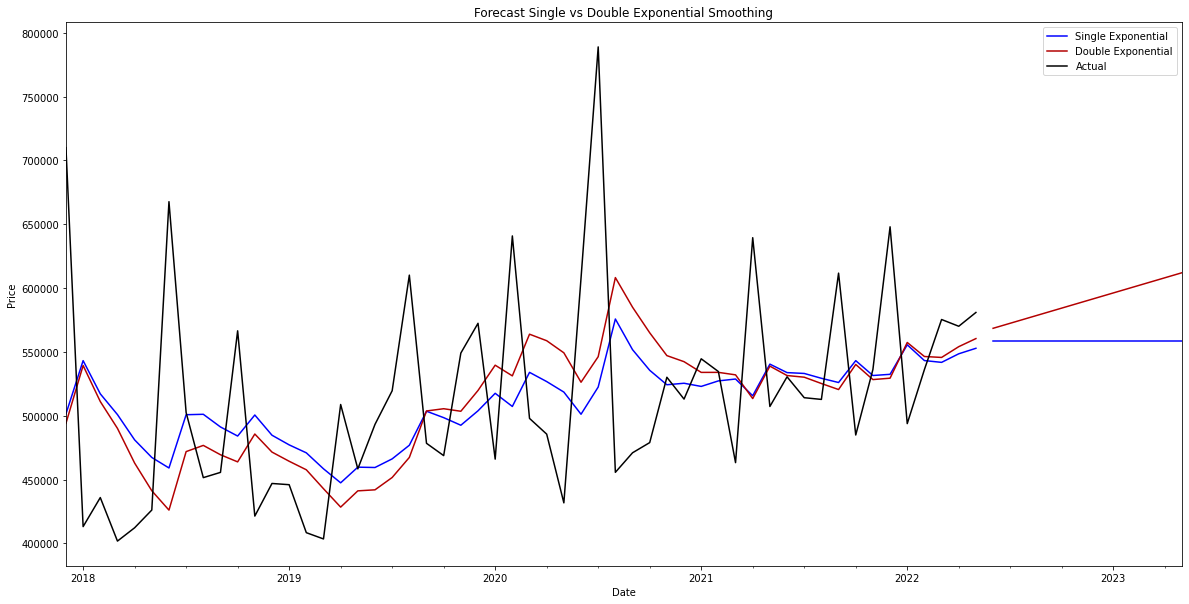

In [10]:
# Double Exponential Smoothing

fig, ax = plt.subplots(figsize=(20, 10))

# plot single
fcast1.plot(color='blue', label="Single Exponential", legend=True)
fit1.fittedvalues.plot(color='blue')

# plot double
fcast4.plot(color='#b30000', label="Double Exponential", legend=True)
fit4.fittedvalues.plot(color='#b30000')

# plot actual values
df.Price.plot(color='black', label="Actual", legend=True)

plt.title('Forecast Single vs Double Exponential Smoothing')
plt.ylabel('Price')
plt.show()

The graph above compare the single and double exponential models with the better performances

## ARIMA

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average

Any ‘non-seasonal’ time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models.

The parameters of the ARIMA model are:

* p (AR): The number of lag observations included in the model, also called the lag order.
* d (I): The number of times that the raw observations are differenced, also called the degree of differencing.
* q (MA): The size of the moving average window, also called the order of moving average.

We will use the retail sales data for this exercise


In [11]:
retail_ds_path = "./DataSets/Retail Sales.csv"

Bellow we will look at how the data looks like

In [12]:
def retail_parser(x):
    return pd.datetime.strptime(x, '%m/%Y')

retail_sales = pd.read_csv(retail_ds_path, header=0, parse_dates=[0], index_col=0, date_parser=retail_parser)
retail_sales.head()

/tmp/ipykernel_714753/702821728.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  return pd.datetime.strptime(x, '%m/%Y')


,Sales
Date,
2019-01-01,266.0
2019-02-01,145.9
2019-03-01,183.1
2019-04-01,119.3
2019-05-01,180.3


And we will plot this data into a graph

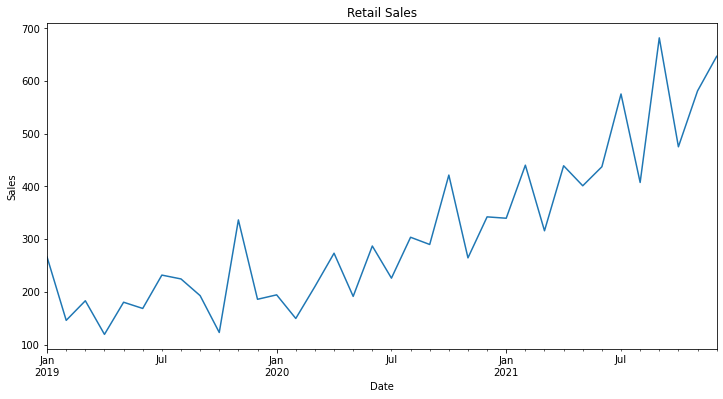

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))

retail_sales.Sales.plot()
plt.title('Retail Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

## Checking Stationarity

We need will now analise if our dataset is stationary or not.

#### Data is considered stationary when its statistical properties don't change over time.

To confirm that this data is stationary we will use The Augmented Dickey-Fuller (ADF), a type of statistical test called a unit root test.

The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.
* The null hypothesis of the test is that the data is not stationary.
* The alternate hypothesis is that the data is stationary.

We interpret this result using the p-value from the test.
* p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
* p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [14]:
result = adfuller(retail_sales.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'{key}: {value:.2f}')

ADF Statistic: 3.060142
p-value: 1.000000
Critical Values:
1%: -3.72
5%: -2.99
10%: -2.63


And we now can confirm that this data is not stationary.

## Defining values for p d q

We will now define the values for p d q.

Let's start with d.

### Autocorrelation plot

We already know that this data is not stationary, in order to make it so, we need to differentiate the data to get a near-stationary series.
Let’s difference the series and see how the autocorrelation plot looks like.

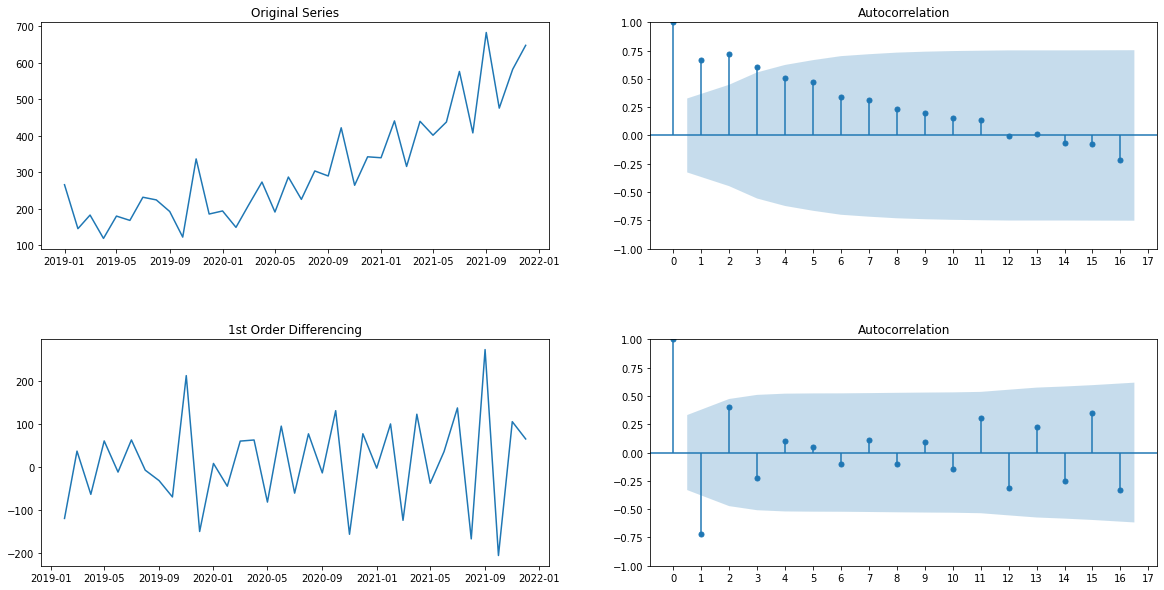

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

# Original Series
ax[0,0].plot(retail_sales.Sales); ax[0,1]
plot_acf(retail_sales, ax=ax[0,1])

# 1st Differencing
ax[1,0].plot(retail_sales.Sales.diff()); ax[1,1]
plot_acf(retail_sales.Sales.diff().dropna(), ax=ax[1,1])

ax[0 , 0].set_title('Original Series')
plt.setp(ax[0,1], xticks=range(18))

ax[1 , 0].set_title('1st Order Differencing')
plt.setp(ax[1,1], xticks=range(18))

plt.subplots_adjust(hspace=0.4)
plt.show()

We will keep 2 rules in mind when defining the value of d.

* __Rule 1:__ If the series has positive autocorrelations out to a high number of lags, then it probably needs a higher order of differencing.
* __Rule 2:__ If the lag-1 autocorrelation is zero or negative, or the autocorrelations are all small and patternless, then the series does not need a higher order of differencing. If the lag-1 autocorrelation is -0.5 or more negative, the series may be overdifferenced.
    _(Robert Nau, Statistical Forecasting)_

we can see from the graphs above that our data reachs a near-stationary state in the first orders of differencing.
So we will define our d as 1.

#### Remember d is the minimum differencing required to get a near-stationary series

Next we will define our value to p, by inspecting the Partial Autocorrelation (PACF) plot.

### Partial Autocorrelation (PACF)

You can think of PACF as the correlation between the series and its lag after excluding the effects from the intermediate lags.
We can say that it gives the pure correlation between a lag and the series.


/home/kelly/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


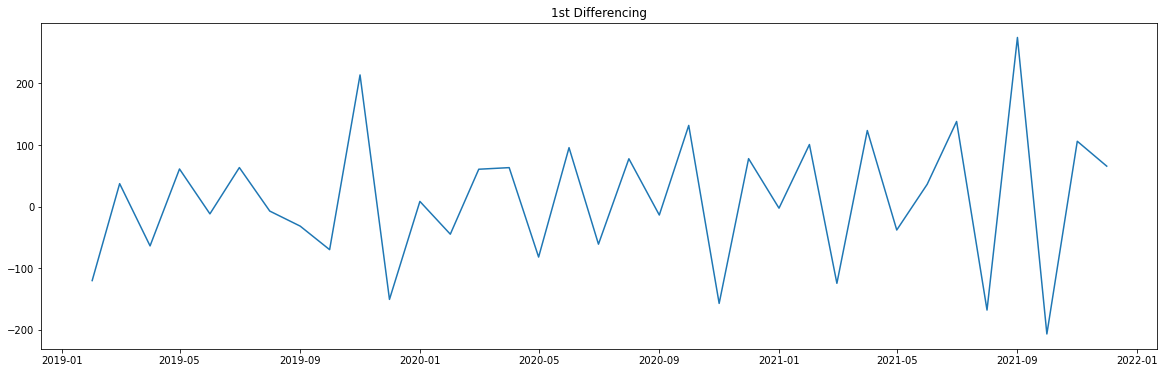

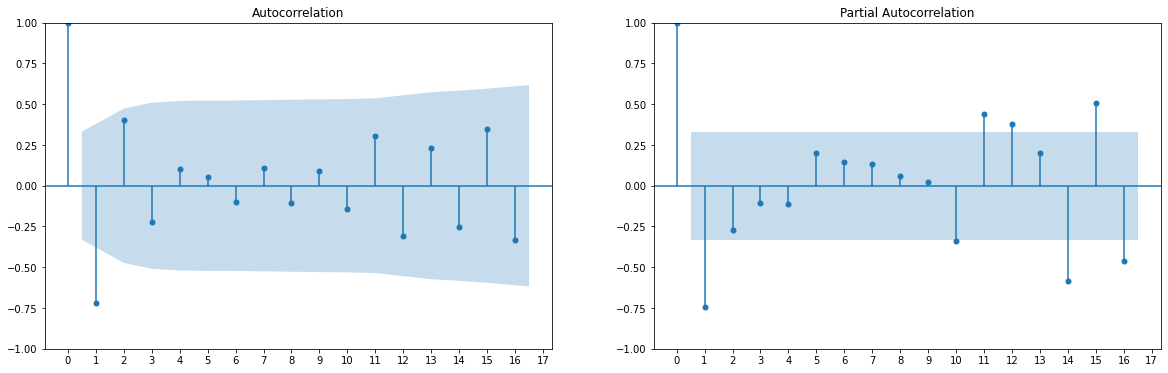

In [16]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(retail_sales.Sales.diff()); ax.set_title('1st Differencing')

# PACF plot of 1st differ,enced series
fig2, ax2 = plt.subplots(1, 2, figsize=(20, 6))


plot_acf(retail_sales.Sales.diff().dropna(), lags=16, ax=ax2[0])
plot_pacf(retail_sales.Sales.diff().dropna(), lags=16, ax=ax2[1])

plt.setp(ax2, xticks=range(18))

plt.show()

We can observe 6 lags crossing the significance limit (lags 1, 11, 12, 14, 15 and 16)
So we can assume that these 6 values impact the present value of d.
So we will define our d value as 6.

And now, we will define the q value similarly as we defined d, but we will look at the ACF graph instead.

And we can observe that only lag-1 crosses the significance limit, so we will define the value of q as 1.

That gives us the following parameters to our model:
* d = 6
* i = 1
* p = 1

### ARIMA MODEL

In [17]:
d = 6
i = 1
p = 1

/home/kelly/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/kelly/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/kelly/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/kelly/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


MAE	RMSE
59.06	78.81


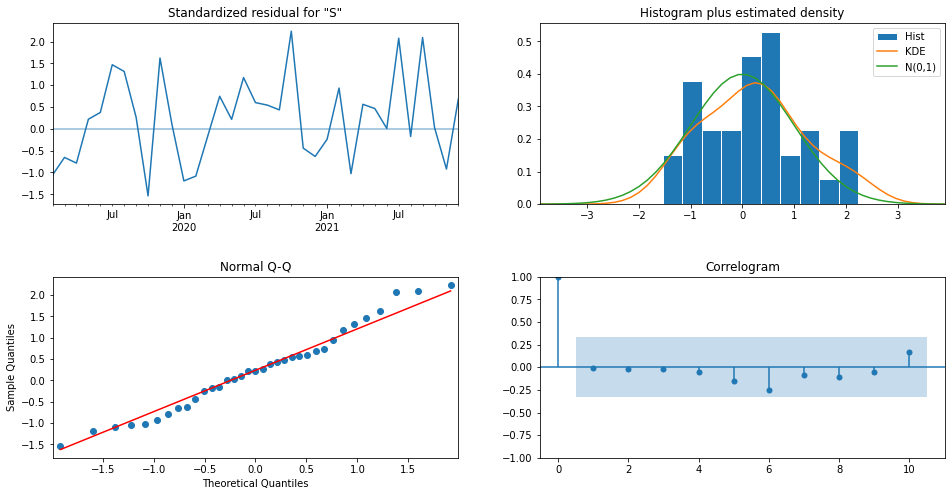

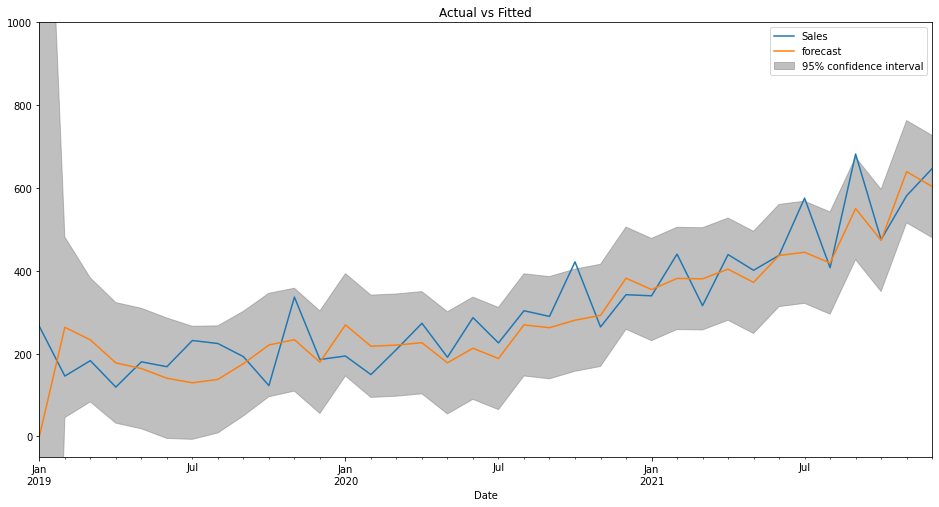

In [18]:
parameters = (d,i,p)

# Fit model
model = ARIMA(retail_sales, order=parameters)
model_fit = model.fit()

# evaluate forecasts
total_obs = len(retail_sales)
ae = [abs(forecast - retail_sales.Sales.iloc[i]) for i, forecast in enumerate(model_fit.fittedvalues)]
mae = sum(ae)/total_obs
rmse = sqrt(model_fit.sse/total_obs)
print("MAE","RMSE", sep="\t")
print(round(mae, 2),round(rmse, 2), sep="\t")

# diagnostics graphs
model_fit.plot_diagnostics(figsize=(16, 8))
plt.subplots_adjust(hspace=0.4)
plt.show()

# Actual vs Fitted
fig, ax = plt.subplots(figsize=(16, 8))
ax = retail_sales.iloc[0:].plot(ax=ax)
fig = plot_predict(model_fit, ax=ax)

plt.ylim([-50, 1000])
plt.legend()
plt.title("Actual vs Fitted")
plt.show()

### Conclusion

1. The top left plot shows the residuals over time. We do not want to see any obvious seasonality here and the messier it is, the better we can say we found the trend and seasonality in our data and removed the noise.

2. In the top-right plot, we want to see that the red KDE line follows closely with the N(0,1) line to indicate that the residuals are normally distributed. This line is the standard notation for a normal distribution with a mean of 0 and a standard deviation of 1.

3. In the bottom left qq-plot, you see the ordered distribution of residuals (blue dots) following the linear trend (red line) of the samples taken from a standard normal distribution with N(0, 1).

4. The autocorrelation visual (called a “correlogram”) on the bottom right shows that the time series residuals have a low correlation with the lagged versions of itself (that is, the majority of dots fall into the blue shaded area).

5. Final plot shows the comparisson of Actual vs Predicted values
